# Training Set Aquisition

## Gregor Fritz and Laurenz Hundgeburth, FH Kärnten Bachelorprojekt

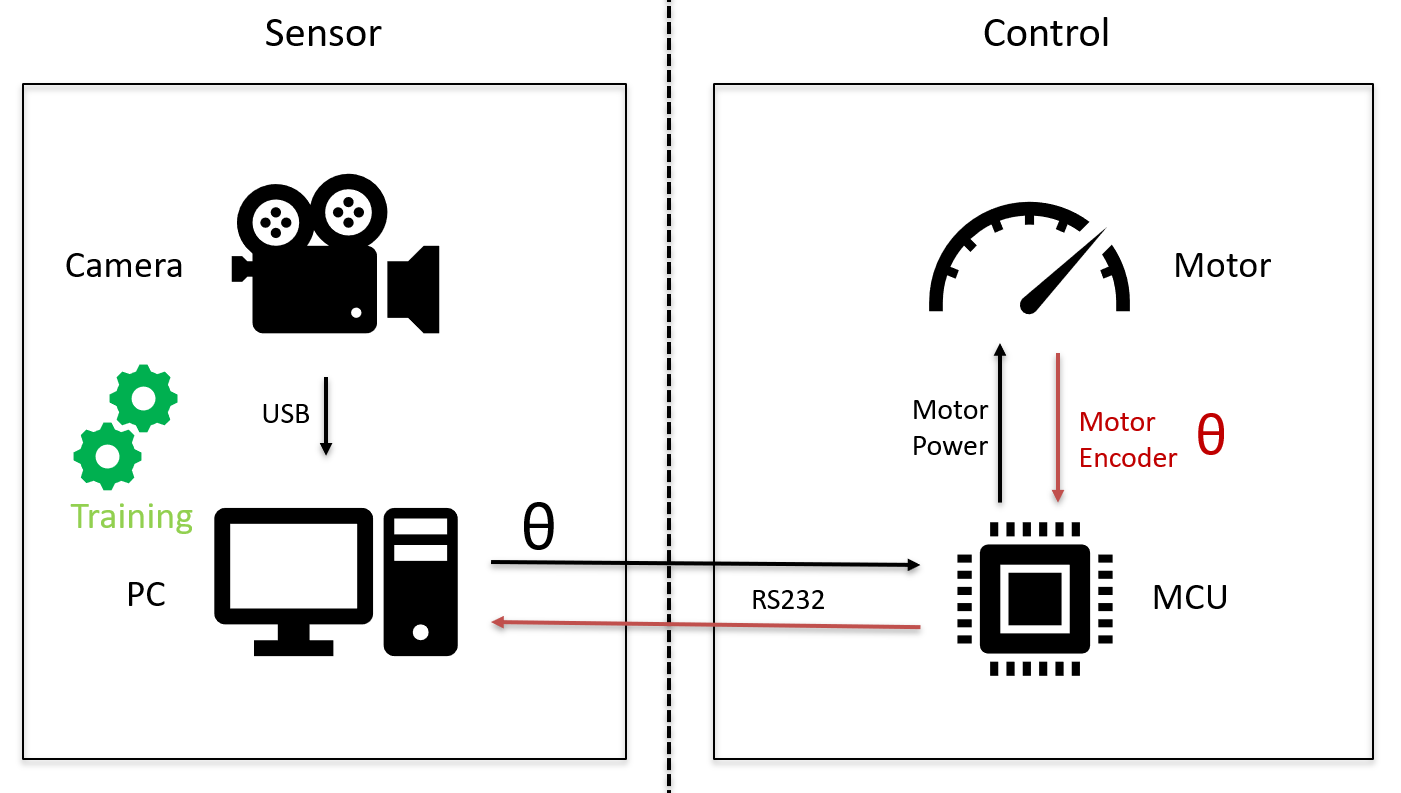

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import csv
import struct
from time import time, sleep
from serial import Serial
from random import randint
from threading import Thread
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [2]:
#Class and Function Definitions

################################################################
#Serial Thread

class Ser(Thread):
    def __init__(self, port):
        super().__init__()
        self._run = True
        self._ser = Serial(port ,115200)
        self._last_value = 0.0
        self._reference = 0.0
        self._expected_reference = 0.0
        self._valid = False

    def get_act_value(self):
        return self._last_value
    
    def value_valid(self):
        return self._valid
    
    def increase_reference(self, random_rad):
        self._expected_reference += random_rad
        self._expected_reference = round(self._expected_reference, 2)
        

    def write_reference(self):
        self._ser.write(str(self._expected_reference).encode('utf-8'))
        self._ser.write('\r\n'.encode('utf-8'))

    def reference_accepted(self):
        return self._expected_reference == self._reference

    def run(self):
        print('Serial Thread running')
        while self._run:
            line = self._ser.readline()
            data = line.split(b',')
            try:
                if len(data) == 3:
                    self._valid = bool(int(data[0]))
                    self._last_value = float(data[1])
                    self._reference = float(data[2])
                    #print(self._valid, self._last_value, self._reference)
                else:
                    raise ValueError
            except ValueError:
                self._last_value = None
                self._reference = None
                self._valid = False

    def end(self):
        self._run = False
        self.join()
        self._ser.close()
        
################################################################
#Camera Thread

class PsEye(Thread):
    def __init__(self):
        super().__init__()
        self._run = True
        self._video = cv2.VideoCapture(0)
        self._last_frame = None

    def get_act_frame(self):
        return self._last_frame

    def run(self):
        while self._run:
            check, frame = self._video.read()
            if check:
                self._last_frame = frame

    def save_last_frame(self, img_file_path, img_name):
        #print('Saving img {}'.format(img_name))
        cv2.imwrite(str(img_file_path + img_name), self._last_frame)

    def end(self):
        self._run = False
        self.join()
        self._video.release()

    def frame_valid(self):
        return self._last_frame is not None

################################################################
#Main Functions
    
def log_csv(file, img_name, label):
    with open(file, 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow([img_name, label])
    pass

Starting Camera Thread...
Camera Thread running...
closing Threads...


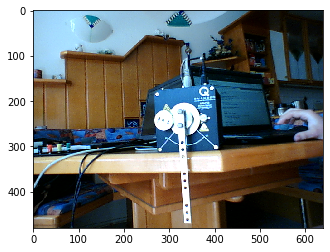

In [5]:
#Camera Image Test
print("Starting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

camera.save_last_frame('./', 'test_image.png')

camera.end()
print("closing Threads...")

img=mpimg.imread('test_image.png')
imgplot = plt.imshow(img)

In [6]:
#Available Ports:
!python -m serial.tools.list_ports

/dev/ttyACM0        
/dev/ttyACM1        
2 ports found


In [7]:
#create new Folder and prepare csv
!mkdir pictures_29_6_19

In [8]:
#create csv 
csvData = [['id', 'label']]

with open('image_labels_29_6_19.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

In [9]:
#Main Programm

port = '/dev/ttyACM1'

csv_file_path = "./image_labels_29_6_19.csv"
img_file_path = "./pictures_29_6_19/"

num_images = 20000

print("#Starting Data Acquisition  -  {} images".format(str(num_images)))
print("#    csv_file_path: {}".format(csv_file_path))
print("#    img_file_path: {}".format(img_file_path))
print("#################################################")

print("Starting Serial Thread...")
ser = Ser(port)
ser.start()
sleep(1)

print("Starting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

img_counter = 0
labels = []

sleep(0.3)

for a in tqdm(range(num_images)):
    #clear_output(wait=True)
    rand_increment = randint(50,80) 
    rand_rad = rand_increment/4096 * (2*np.pi)
    counter = 0
    attempt_valid = True
    ser.increase_reference(rand_rad)
    sleep(0.05) #Time to make shure new reference got written
    while True:
        if not ser.reference_accepted():
            ser.write_reference()
            sleep(0.01)
            counter += 1
            if counter >= 10: # 50 Milliseconds
                attempt_valid = False
                break
        else:
            break
    
    if attempt_valid:
        counter = 0
        while True:
            if ser.value_valid():
                break
            else:
                sleep(0.005)
                counter += 1
                if counter >= 60: # 300 Milliseconds
                    attempt_valid = False
                    break
    
    if ser.value_valid() and attempt_valid:
        label = ser.get_act_value()
        label =round(label %(2*np.pi), 2)
        img_name = "{}_{}.png".format(time(), label)
        camera.save_last_frame(img_file_path, img_name)
        log_csv(csv_file_path, img_name, label)
        img_counter += 1
        #print('attempt {} successful!'.format(a+1))
        labels.append(label)
    else:
        pass
        #print('attempt {} FAILED!'.format(a+1))
        
print("#################################################")
print("#{} out of {} attempts successful".format(img_counter, num_images))
camera.end()
ser.end()
print("#closing Threads...")

#Starting Data Acquisition  -  20000 images
#    csv_file_path: ./image_labels_29_6_19.csv
#    img_file_path: ./pictures_29_6_19/
#################################################
Starting Serial Thread...
Serial Thread running
Starting Camera Thread...
Camera Thread running...


 51%|█████     | 10114/20000 [20:54<21:40,  7.60it/s]

KeyboardInterrupt: 

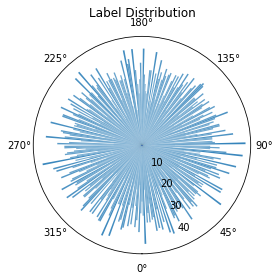

In [11]:
#Result Analysis1: Polar Histogramm
from scipy.interpolate import interp1d

#interpol = interp1d([min(labels), max(labels)], [0.4, 0.8])

bins_number = 360  # the [0, 2pi] interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
n, _, _ = plt.hist(labels, bins)

interpol = interp1d([0, max(n)], [0, 0.9])

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
d_alpha = 0.03
alpha = 0.4
count = 0
for bar in bars:
    bar.set_alpha(interpol(n[count]))
    alpha += d_alpha
    count += 1
ax.set_theta_zero_location("S")
#ax.set_theta_direction(-1)
ax.set_title("Label Distribution", va='bottom')
ax.grid(False)
#ax.set_rticks([1, 2, 3, 4])
plt.show()